**Chest X-Ray Screening for Pneumonia using Machine learning**

**Author**: Akash Kumar Yadav  
**Course**: CISC 5800 - Machine Learning  
**Professor**: Juntao Chen  
**Institution**: Fordham University  
**Date**: December 2024

---

## Project Overview

**Objective**: Develop a deep learning model to detect pneumonia from chest X-ray images with high sensitivity (recall ≥95%) for clinical screening applications.

### What is Pneumonia?
An inflammatory infection filling lung alveoli, often causing cough, fever, chest pain, and breathing difficulty, primarily from bacteria or viruses, and riskier for people with COPD, asthma, diabetes, or heart disease.

### Dataset
- **Source**: Chest X-Ray Images (Pneumonia) dataset
- **Classes**: Normal vs Pneumonia
- **Total Images**: ~5,840 images
- **Split**: Train, Validation, Test

### Models Evaluated
1. **Custom CNN**: Built from scratch
2. **VGG16**: Transfer learning (ImageNet pre-trained)
3. **ResNet50**: Transfer learning (ImageNet pre-trained)

---

## 1. Setup and Configuration

### 1.1 Import Required Libraries

In [4]:
# Import Libraries
import os
import random
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, auc
)

### 1.2 Reproducibility Setup
Setting random seeds for reproducible results and configuring device (GPU/CPU).

In [5]:
# For reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

print("Torch version:", torch.__version__)
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print(f"Using device: {device}")
device

Torch version: 2.9.1
Using device: mps


device(type='mps')

### 1.3 Directory Structure & Constants
Defining paths for data, models, and results storage.

In [6]:
# Path Setup & Constants
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / "chest_xray"
TRAIN_DIR_ORIG = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
VAL_DIR = DATA_DIR / "val"

RESULTS_DIR = BASE_DIR / "results_notebook_1"
RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR = BASE_DIR / "models_1"
MODELS_DIR.mkdir(exist_ok=True)

# Constants
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 1e-3
PATIENCE = 5
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

print("BASE_DIR:", BASE_DIR)
print("Train dir exists:", TRAIN_DIR_ORIG.exists())
print("Test dir exists:", TEST_DIR.exists())
print("Val dir exists:", VAL_DIR.exists())
print("Results dir:", RESULTS_DIR)

BASE_DIR: /Users/akashkinu/Developer/ChestXrayProject
Train dir exists: True
Test dir exists: True
Val dir exists: True
Results dir: /Users/akashkinu/Developer/ChestXrayProject/results_notebook_1


---

## 2. Data Preparation

### 2.1 Data Augmentation & Transformations
Defining image preprocessing pipelines with augmentation for training and standard transforms for validation/testing.

**Training Augmentations**:
- Random rotation (±15°)
- Random horizontal flip
- Color jitter (brightness, contrast)
- Random affine transformations
- Normalization (ImageNet stats)

**Validation/Test Transforms**:
- Resize to 224×224
- Normalization only

In [7]:
# Data Transformation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=str(TRAIN_DIR_ORIG), transform=train_transform)
print(f"Full training dataset size: {len(full_train_dataset)}")
print(f"Classes: {full_train_dataset.classes}")

Full training dataset size: 5216
Classes: ['NORMAL', 'PNEUMONIA']


### 2.2 Load Datasets
Loading the chest X-ray dataset using PyTorch's ImageFolder.

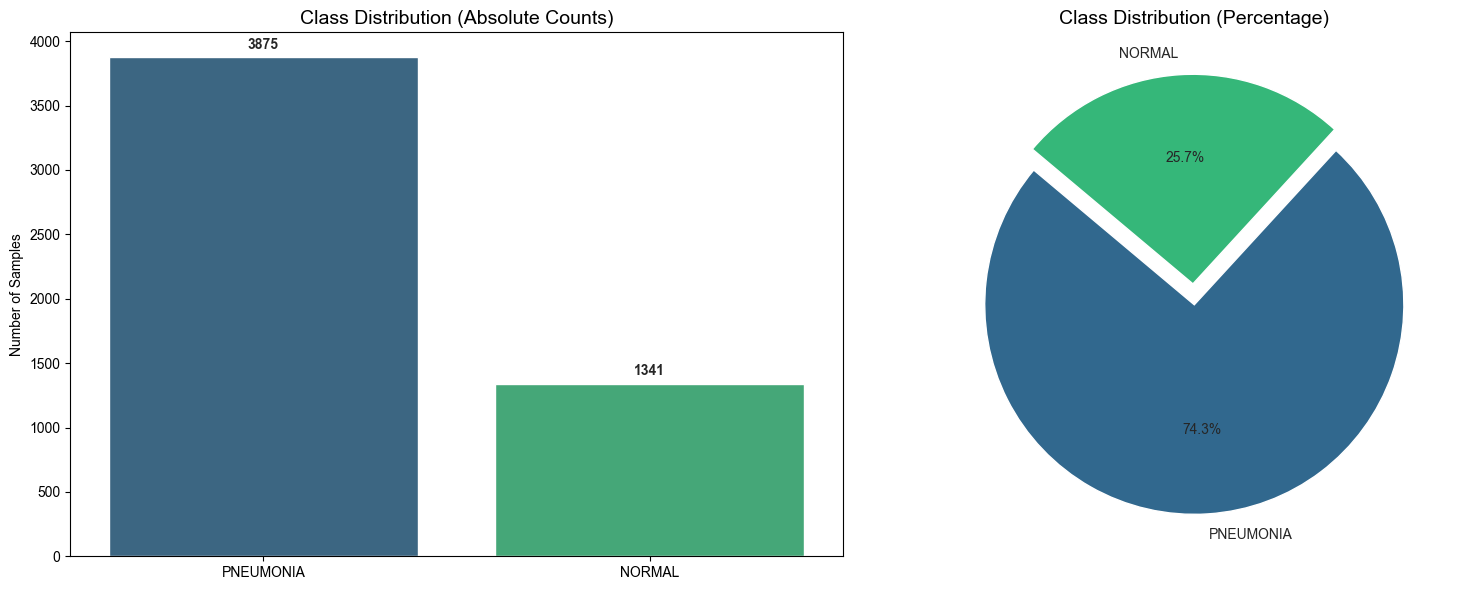

In [8]:
# Ensure dataset is available for visualization
if 'full_train_dataset' not in globals():
    BASE_DIR = Path().resolve()
    TRAIN_DIR_ORIG = BASE_DIR / "chest_xray" / "train"
    if 'train_transform' not in globals():
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    full_train_dataset = datasets.ImageFolder(root=str(TRAIN_DIR_ORIG), transform=train_transform)

# Compute class distribution directly from the ImageFolder targets
class_counts = Counter(full_train_dataset.targets)
data = []
for class_idx, class_name in enumerate(full_train_dataset.classes):
    data.append({
        "Class Type": class_name,
        "Count": class_counts.get(class_idx, 0)
    })

df = pd.DataFrame(data).sort_values(by="Count", ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("whitegrid")

# Bar Chart (Absolute Numbers)
sns.barplot(x="Class Type", y="Count", data=df, ax=ax1, palette="viridis", hue="Class Type")

for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', 
                 xytext=(0, 9), 
                 textcoords='offset points',
                 fontweight='bold')

ax1.set_title("Class Distribution (Absolute Counts)", fontsize=14)
ax1.set_ylabel("Number of Samples")
ax1.set_xlabel("")

# Pie Chart (Percentage Share)
colors = sns.color_palette('viridis', len(df))
ax2.pie(df["Count"], labels=df["Class Type"], autopct='%1.1f%%', 
        startangle=140, colors=colors, explode=[0.05] * len(df))
ax2.set_title("Class Distribution (Percentage)", fontsize=14)

plt.tight_layout()
plt.show()

### 2.3 Stratified Train-Validation Split
Creating an 85-15 stratified split to maintain class distribution (15% for validation).

In [9]:
# Data Splitting (Enhanced)
targets = [y for _, y in full_train_dataset.samples]
train_idx, val_idx = train_test_split(
    np.arange(len(full_train_dataset)),
    test_size=0.15,
    stratify=targets,
    random_state=42
)

train_dataset = Subset(full_train_dataset, train_idx)

# For validation we use eval_transform (no augmentation)
full_train_dataset_eval = datasets.ImageFolder(root=str(TRAIN_DIR_ORIG), transform=eval_transform)
val_dataset = Subset(full_train_dataset_eval, val_idx)

test_dataset = datasets.ImageFolder(root=str(TEST_DIR), transform=eval_transform)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 4433
Val size: 783
Test size: 624


### 2.4 Analyze Class Distribution
Examining class balance across train, validation, and test sets to identify imbalance.

**Note**: Dataset is imbalanced (~3:1 ratio Pneumonia:Normal), which will be addressed with class weighting.

Train class distribution: Counter({1: 3293, 0: 1140})
Val class distribution: Counter({1: 582, 0: 201})
Test class distribution: Counter({1: 390, 0: 234})


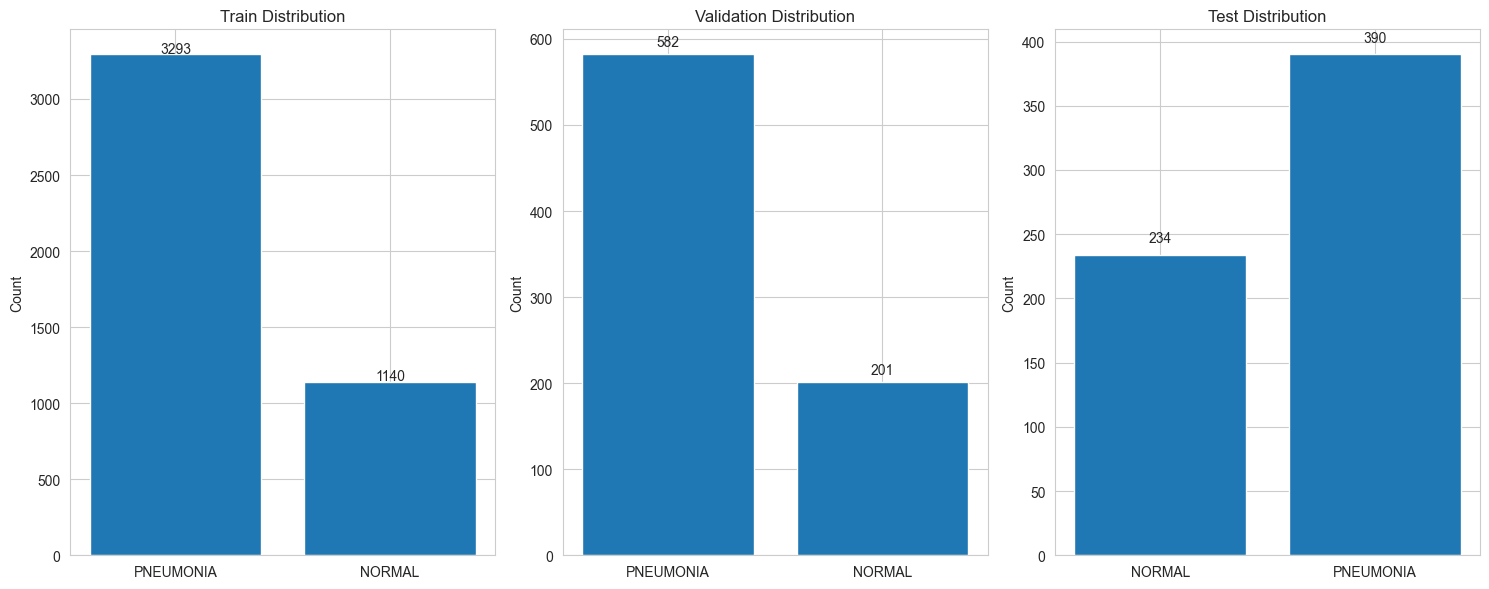

Class weights: tensor([1.9443, 0.6731], device='mps:0')


In [10]:
# Class distribution in train set
train_labels = [full_train_dataset.samples[i][1] for i in train_idx]
val_labels = [full_train_dataset.samples[i][1] for i in val_idx]

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_dataset.targets)

print("Train class distribution:", train_counts)
print("Val class distribution:", val_counts)
print("Test class distribution:", test_counts)

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for ax, counts, title in zip(axes, [train_counts, val_counts, test_counts], 
                            ['Train', 'Validation', 'Test']):
    ax.bar([CLASS_NAMES[i] for i in counts.keys()], counts.values())
    ax.set_title(f'{title} Distribution')
    ax.set_ylabel('Count')
    for i, v in enumerate(counts.values()):
        ax.text(i, v + 10, str(v), ha='center') 
plt.tight_layout()
plt.savefig(RESULTS_DIR / "class_distribution.png", dpi=300)
plt.show()

# Class weights for loss function
normal_count = train_counts[0]
pneu_count = train_counts[1]
total = len(train_labels)

class_weights = torch.tensor(
    [total / (2 * normal_count), total / (2 * pneu_count)],
    dtype=torch.float32,
    device=device
)
print(f"Class weights: {class_weights}")

### 2.5 Create Data Loaders
Setting up PyTorch DataLoaders with batching for efficient training.

**Configuration**:
- Batch size: 32
- Num workers: 2
- Pin memory: False (for compatibility)

In [11]:
# Data Loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=False
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=False
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=False
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 139
Val batches: 25
Test batches: 20


---

## 3. Exploratory Data Analysis

### 3.1 Visualize Sample Images
Displaying sample chest X-rays from both classes to understand the data.

Batch shape: torch.Size([32, 3, 224, 224])


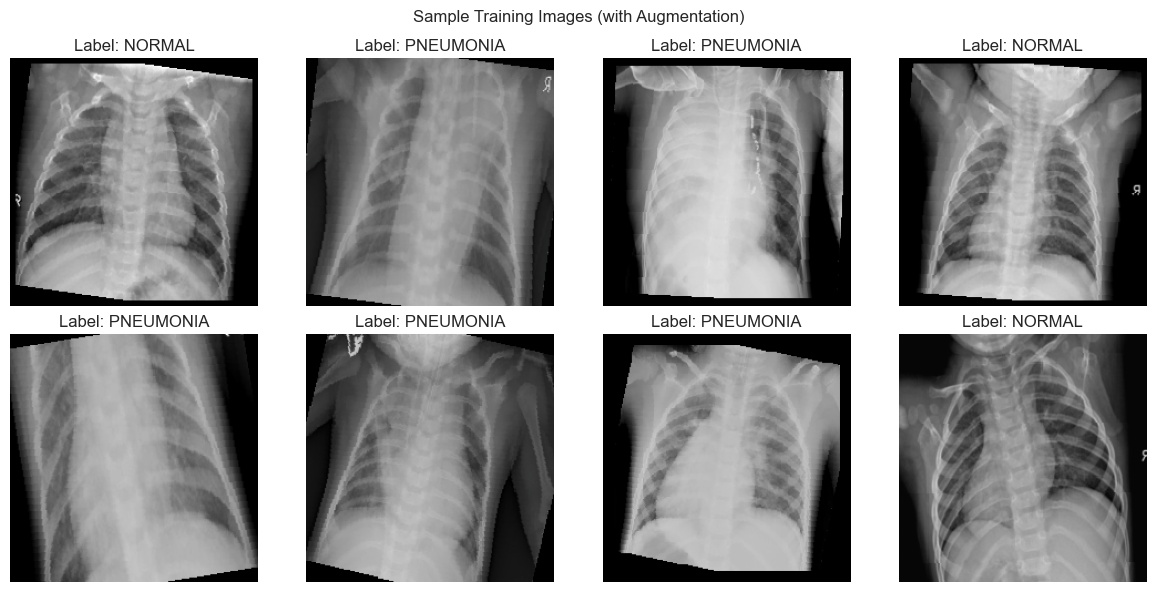

In [12]:
# Data Visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize tensor for visualization"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Visualize sample batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    ax = axes[i//4, i%4]
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"Label: {CLASS_NAMES[labels[i]]}")
    ax.axis('off')
plt.suptitle("Sample Training Images (with Augmentation)")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "sample_images.png", dpi=300)
plt.show()

---

## 4. Model Architecture

### 4.1 Define Model Architectures
Implementing three different architectures for comparison:

**1. Custom CNN**
- 4 convolutional blocks (32→64→128→256 filters)
- Batch normalization after each conv layer
- Max pooling for downsampling
- Dropout (0.5) for regularization
- Fully connected classifier

**2. VGG16 (Transfer Learning)**
- Pre-trained on ImageNet
- Modified classifier head
- Fine-tuning approach

**3. ResNet50 (Transfer Learning)**
- Pre-trained on ImageNet
- Deep residual connections
- Modified final layers

In [13]:
# Model Definitions
import torch.nn.functional as F

# Custom CNN Model
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Calculate size after convolutions and pooling
        self._to_linear = None
        self._get_conv_output((3, 224, 224))
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output = self._forward_features(input)
        self._to_linear = output.view(batch_size, -1).size(1)
        return output
    
    def _forward_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# VGG16 Model (Transfer Learning)
def get_vgg16_model():
    weights = models.VGG16_Weights.DEFAULT  # use new weights API
    model = models.vgg16(weights=weights)
    # Freeze feature extraction layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Modify classifier
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 2)
    )
    return model

# ResNet50 Model (Transfer Learning)
def get_resnet50_model():
    weights = models.ResNet50_Weights.DEFAULT  # use new weights API
    model = models.resnet50(weights=weights)
    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last few layers
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    # Modify final layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 2)
    )
    return model

# Create model instances
custom_model = PneumoniaCNN().to(device)
vgg16_model = get_vgg16_model().to(device)
resnet50_model = get_resnet50_model().to(device)

print(f"Custom CNN parameters: {sum(p.numel() for p in custom_model.parameters()):,}")
print(f"VGG16 parameters: {sum(p.numel() for p in vgg16_model.parameters()):,}")
print(f"ResNet50 parameters: {sum(p.numel() for p in resnet50_model.parameters()):,}")

# Test forward pass
test_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    custom_output = custom_model(test_input)
    print(f"\nCustom model output shape: {custom_output.shape}")

Custom CNN parameters: 26,211,842
VGG16 parameters: 121,676,610
ResNet50 parameters: 26,132,034

Custom model output shape: torch.Size([2, 2])


### 4.2 Training Utilities & Helper Functions
Implementing early stopping, training loop, and evaluation functions.

**Key Components**:
- **EarlyStopping**: Monitors validation loss and stops training when no improvement
- **train_epoch**: Single epoch training with progress tracking
- **eval_epoch**: Validation/test evaluation
- **train_model**: Complete training pipeline with history tracking

In [14]:
# Training Utilities
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        
    def __call__(self, val_loss, model, model_name):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_name)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_name)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model, model_name):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), MODELS_DIR / f'{model_name}_best.pth')
        self.val_loss_min = val_loss

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

def train_model(model, model_name, train_loader, val_loader, device, 
                num_epochs=25, learning_rate=1e-3, class_weights=None):
    """Complete training loop"""
    # Loss and optimizer
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)
    
    # History
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)
        
        # Calculate additional metrics
        val_precision = precision_score(val_labels, val_preds, zero_division=0)
        val_recall = recall_score(val_labels, val_preds, zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, zero_division=0)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        
        # Print progress
        print(f"Epoch {epoch+1:02d}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
              f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
        
        # Early stopping check
        early_stopping(val_loss, model, model_name)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    # Load best model
    model.load_state_dict(torch.load(MODELS_DIR / f'{model_name}_best.pth'))
    
    return model, history

---

## 5. Model Training

### 5.1 Train All Three Models
Training Custom CNN, VGG16, and ResNet50 with the following configuration:

**Hyperparameters**:
- Epochs: 25
- Batch size: 32
- Learning rates:
  - Custom CNN: 1e-3
  - VGG16: 1e-4 (10× reduced)
  - ResNet50: 1e-4 (10× reduced)
- Optimizer: Adam
- Loss: CrossEntropyLoss with class weights
- Scheduler: ReduceLROnPlateau
- Early stopping patience: 7 epochs

**Techniques Applied**:
- Class weighting to handle imbalance
- Data augmentation for robustness
- Early stopping to prevent overfitting
- Learning rate scheduling

In [15]:
# Train Custom CNN
custom_model, custom_history = train_model(
    custom_model, "custom_cnn", train_loader, val_loader, device,
    num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, class_weights=class_weights
)

# Train VGG16
vgg16_model, vgg16_history = train_model(
    vgg16_model, "vgg16", train_loader, val_loader, device,
    num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE/10, class_weights=class_weights
)

# Train ResNet50
resnet50_model, resnet50_history = train_model(
    resnet50_model, "resnet50", train_loader, val_loader, device,
    num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE/10, class_weights=class_weights
)

# Save training histories
histories = {
    'custom_cnn': custom_history,
    'vgg16': vgg16_history,
    'resnet50': resnet50_history
}

import pickle
with open(RESULTS_DIR / 'training_histories.pkl', 'wb') as f:
    pickle.dump(histories, f)
print("\nTraining histories saved.")


Training custom_cnn
Epoch 01/25: Train Loss: 1.0274, Train Acc: 77.13% | Val Loss: 0.2619, Val Acc: 91.44% | Precision: 0.9725, Recall: 0.9107
Validation loss decreased (inf --> 0.261878). Saving model...
Epoch 02/25: Train Loss: 0.3128, Train Acc: 87.64% | Val Loss: 0.2363, Val Acc: 86.97% | Precision: 0.9979, Recall: 0.8265
Validation loss decreased (0.261878 --> 0.236326). Saving model...
Epoch 03/25: Train Loss: 0.2665, Train Acc: 89.47% | Val Loss: 0.1486, Val Acc: 94.76% | Precision: 0.9839, Recall: 0.9450
Validation loss decreased (0.236326 --> 0.148576). Saving model...
Epoch 04/25: Train Loss: 0.2122, Train Acc: 92.26% | Val Loss: 0.1767, Val Acc: 89.40% | Precision: 0.9980, Recall: 0.8591
EarlyStopping counter: 1 out of 5
Epoch 05/25: Train Loss: 0.1992, Train Acc: 91.90% | Val Loss: 0.1391, Val Acc: 91.44% | Precision: 0.9961, Recall: 0.8883
Validation loss decreased (0.148576 --> 0.139130). Saving model...
Epoch 06/25: Train Loss: 0.1984, Train Acc: 92.65% | Val Loss: 0.16

### 5.2 Training History Visualization
Plotting loss and accuracy curves to monitor training progress and detect overfitting.

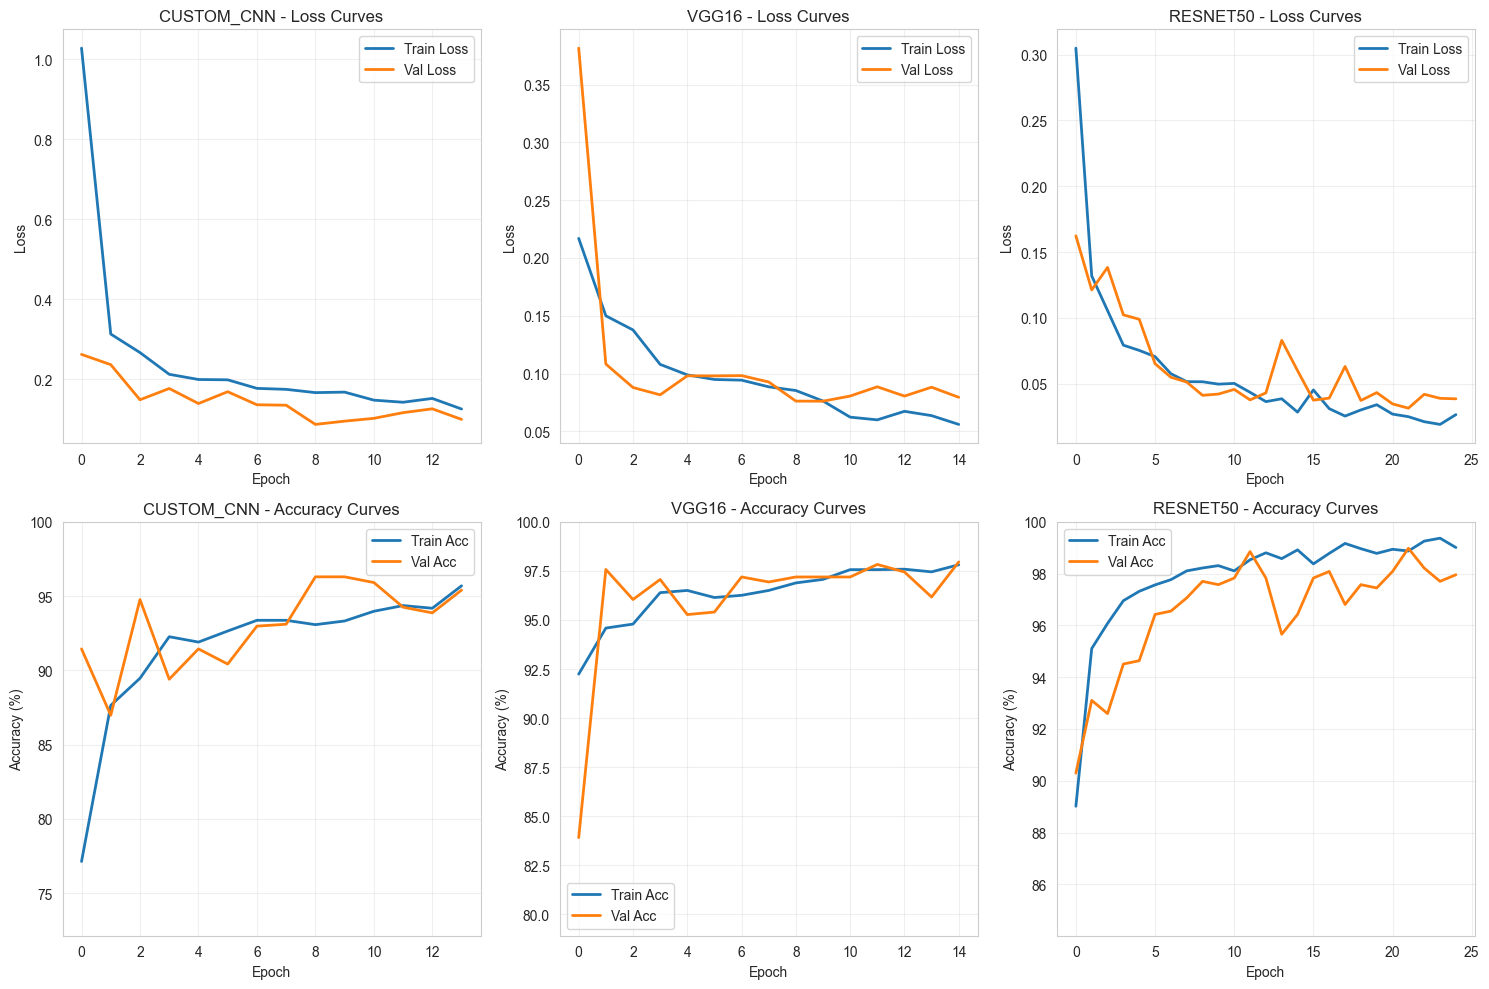

In [16]:
# Plot Training Curves
def plot_training_curves(histories, model_names):
    """Plot training and validation curves"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for idx, model_name in enumerate(model_names):
        history = histories[model_name]
        
        # Loss curves
        ax = axes[0, idx]
        ax.plot(history['train_loss'], label='Train Loss', linewidth=2)
        ax.plot(history['val_loss'], label='Val Loss', linewidth=2)
        ax.set_title(f'{model_name.upper()} - Loss Curves')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Accuracy curves
        ax = axes[1, idx]
        ax.plot(history['train_acc'], label='Train Acc', linewidth=2)
        ax.plot(history['val_acc'], label='Val Acc', linewidth=2)
        ax.set_title(f'{model_name.upper()} - Accuracy Curves')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Set y-lim for accuracy to see differences better
        all_acc = history['train_acc'] + history['val_acc']
        ax.set_ylim([min(all_acc)-5, min(100, max(all_acc)+5)])
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots
plot_training_curves(histories, ['custom_cnn', 'vgg16', 'resnet50'])

---

## 6. Model Evaluation & Testing

### 6.1 Comprehensive Model Evaluation
Evaluating all trained models on the test set with multiple metrics:
- Accuracy
- Precision (positive predictive value)
- Recall/Sensitivity (true positive rate) - **Most important for clinical use**
- F1-Score (harmonic mean of precision and recall)
- ROC-AUC (area under ROC curve)
- Confusion Matrix

**Clinical Requirement**: Recall ≥ 95% to minimize missed pneumonia cases (false negatives).

EVALUATING MODELS ON TEST SET...

COMPREHENSIVE EVALUATION - CUSTOM_CNN
Accuracy:  0.8221
Precision: 0.7888
Recall:    0.9769
F1-Score:  0.8729
ROC-AUC:   0.9236

Confusion Matrix:
[[132 102]
 [  9 381]]

Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.56      0.70       234
   PNEUMONIA       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624



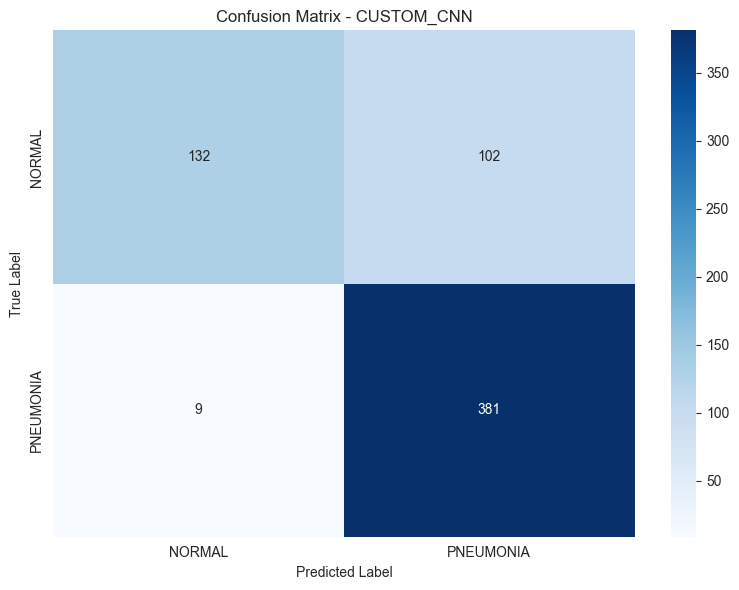

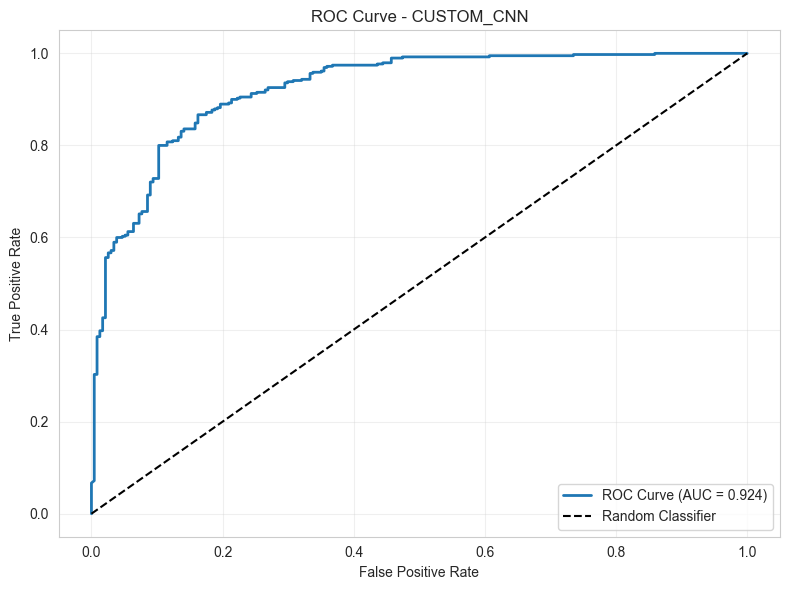




COMPREHENSIVE EVALUATION - VGG16
Accuracy:  0.8718
Precision: 0.8384
Recall:    0.9846
F1-Score:  0.9057
ROC-AUC:   0.9656

Confusion Matrix:
[[160  74]
 [  6 384]]

Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.68      0.80       234
   PNEUMONIA       0.84      0.98      0.91       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.89      0.87      0.87       624



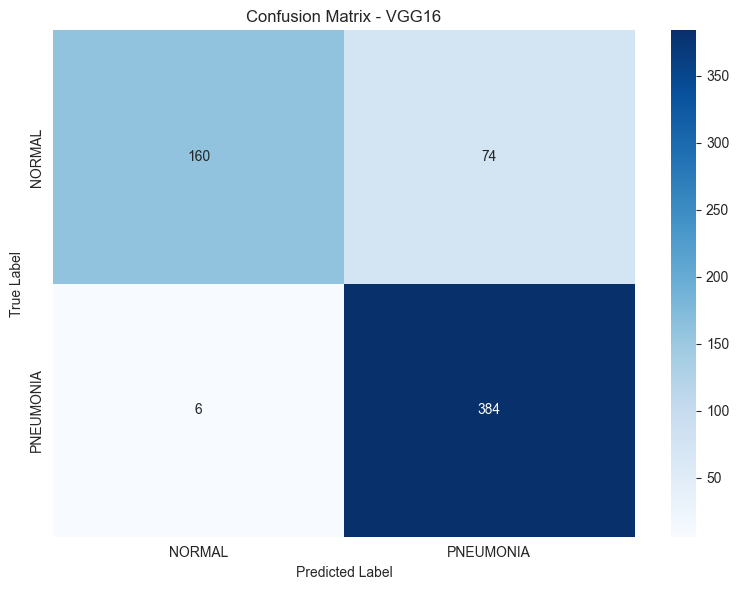

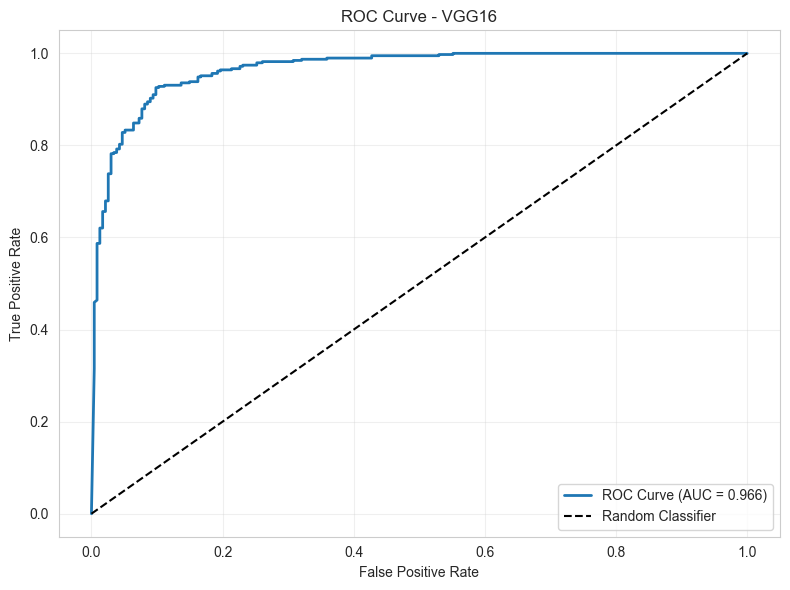




COMPREHENSIVE EVALUATION - RESNET50
Accuracy:  0.8349
Precision: 0.7923
Recall:    0.9974
F1-Score:  0.8831
ROC-AUC:   0.9745

Confusion Matrix:
[[132 102]
 [  1 389]]

Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.56      0.72       234
   PNEUMONIA       0.79      1.00      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.87      0.83      0.82       624



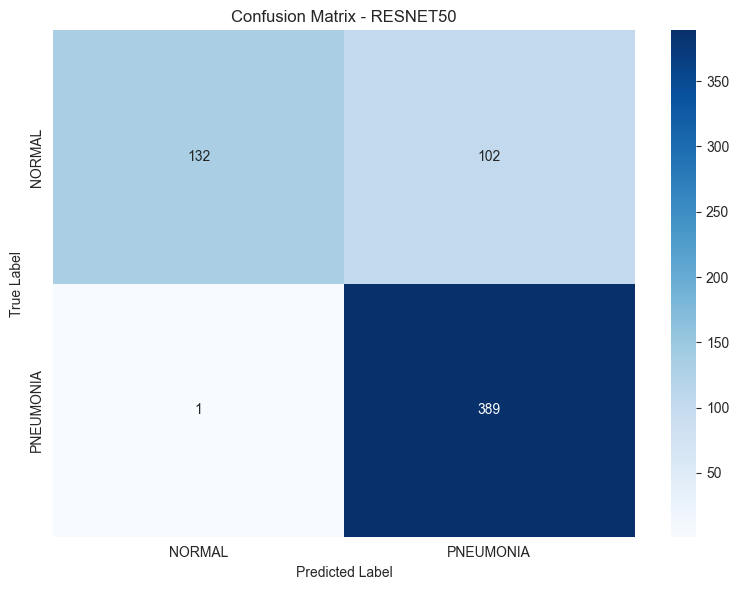

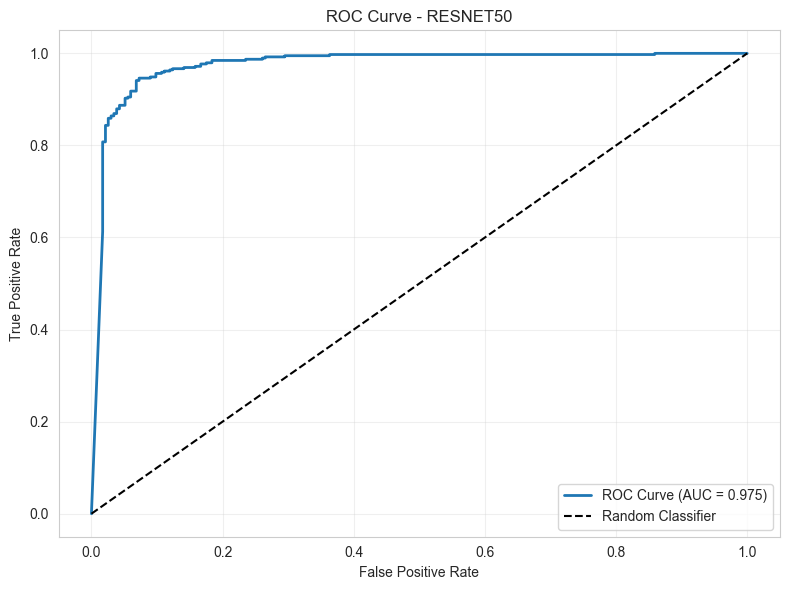

In [17]:
# Comprehensive Evaluation
def evaluate_model_comprehensive(model, dataloader, device, model_name=""):
    """Comprehensive evaluation with all metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy()[:, 1])  # Probability of pneumonia class
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probs)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Classification report
    report = classification_report(all_labels, all_preds, 
                                   target_names=CLASS_NAMES, 
                                   output_dict=True)
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE EVALUATION - {model_name.upper()}")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    print(f"\nConfusion Matrix:")
    print(cm)
    
    print(f"\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix - {model_name.upper()}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'confusion_matrix_{model_name}.png', dpi=300)
    plt.show()
    
    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name.upper()}')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'roc_curve_{model_name}.png', dpi=300)
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'classification_report': report,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

# Evaluate all models on test set
print("EVALUATING MODELS ON TEST SET...")
print("="*60)

eval_results = {}
for model, name in [(custom_model, 'custom_cnn'), 
                    (vgg16_model, 'vgg16'), 
                    (resnet50_model, 'resnet50')]:
    results = evaluate_model_comprehensive(model, test_loader, device, name)
    eval_results[name] = results
    print("\n" + "="*60 + "\n")

# Save evaluation results
with open(RESULTS_DIR / 'evaluation_results.pkl', 'wb') as f:
    pickle.dump(eval_results, f)

### 6.2 Model Performance Comparison
Creating a comprehensive comparison table of all three models.

In [18]:
# Create comparison table
comparison_data = []
for model_name, results in eval_results.items():
    comparison_data.append({
        'Model': model_name.upper(),
        'Accuracy': f"{results['accuracy']:.4f}",
        'Precision': f"{results['precision']:.4f}",
        'Recall': f"{results['recall']:.4f}",
        'F1-Score': f"{results['f1']:.4f}",
        'ROC-AUC': f"{results['roc_auc']:.4f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nMODEL PERFORMANCE COMPARISON (Test Set):")
print("="*60)
print(df_comparison.to_string(index=False))

# Save to CSV
df_comparison.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)

# Pick single best model: highest recall, tie-break by F1
max_recall = max(v['recall'] for v in eval_results.values())
recall_tied = [k for k, v in eval_results.items() if v['recall'] == max_recall]
best_model_name = max(recall_tied, key=lambda x: eval_results[x]['f1'])
best_model_results = eval_results[best_model_name]

print(f"\n{'='*60}")
print("BEST MODEL (Recall first, F1 tie-break):")
print(f"Model: {best_model_name.upper()}")
print(f"Recall: {best_model_results['recall']:.4f}")
print(f"F1-Score: {best_model_results['f1']:.4f}")
print(f"Meets recall ≥95% target: {'✓ YES' if best_model_results['recall'] >= 0.95 else '✗ NO'}")
print(f"{'='*60}")

if best_model_results['recall'] < 0.95:
    print("\n WARNING: Model does not meet the recall ≥95% target.")
    print("Consider: More data, class balancing, or model tuning.")



MODEL PERFORMANCE COMPARISON (Test Set):
     Model Accuracy Precision Recall F1-Score ROC-AUC
CUSTOM_CNN   0.8221    0.7888 0.9769   0.8729  0.9236
     VGG16   0.8718    0.8384 0.9846   0.9057  0.9656
  RESNET50   0.8349    0.7923 0.9974   0.8831  0.9745

BEST MODEL (Recall first, F1 tie-break):
Model: RESNET50
Recall: 0.9974
F1-Score: 0.8831
Meets recall ≥95% target: ✓ YES


### 6.3 Per-Class Performance Breakdown
Analyzing model performance separately for Normal vs Pneumonia classes to identify class-specific strengths and weaknesses.

In [19]:
# Per-Class Performance Analysis - Function Definition
def analyze_per_class_performance(models_dict, test_loader, device):
    """Calculate accuracy, precision, recall for each class separately"""
    
    results = []
    class_names = ['Normal', 'Pneumonia']
    
    for model_name, model in models_dict.items():
        model.eval()
        
        # Per-class counters
        class_correct = [0, 0]
        class_total = [0, 0]
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                for class_idx in range(2):
                    mask = (labels == class_idx)
                    class_total[class_idx] += mask.sum().item()
                    class_correct[class_idx] += ((predicted == labels) & mask).sum().item()
        
        # Calculate per-class accuracy
        for class_idx in range(2):
            accuracy = 100 * class_correct[class_idx] / class_total[class_idx]
            results.append({
                'Model': model_name,
                'Class': class_names[class_idx],
                'Total': class_total[class_idx],
                'Correct': class_correct[class_idx],
                'Accuracy (%)': accuracy
            })
    
    return pd.DataFrame(results)

In [20]:
# Run Per-Class Analysis
models_to_analyze = {
    'Custom CNN': custom_model,
    'VGG16': vgg16_model,
    'ResNet50': resnet50_model
}

per_class_df = analyze_per_class_performance(models_to_analyze, test_loader, device)

# Display results
print("\n" + "="*70)
print("PER-CLASS PERFORMANCE BREAKDOWN")
print("="*70)
print(per_class_df.to_string(index=False))
print("="*70)


PER-CLASS PERFORMANCE BREAKDOWN
     Model     Class  Total  Correct  Accuracy (%)
Custom CNN    Normal    234      132     56.410256
Custom CNN Pneumonia    390      381     97.692308
     VGG16    Normal    234      160     68.376068
     VGG16 Pneumonia    390      384     98.461538
  ResNet50    Normal    234      132     56.410256
  ResNet50 Pneumonia    390      389     99.743590


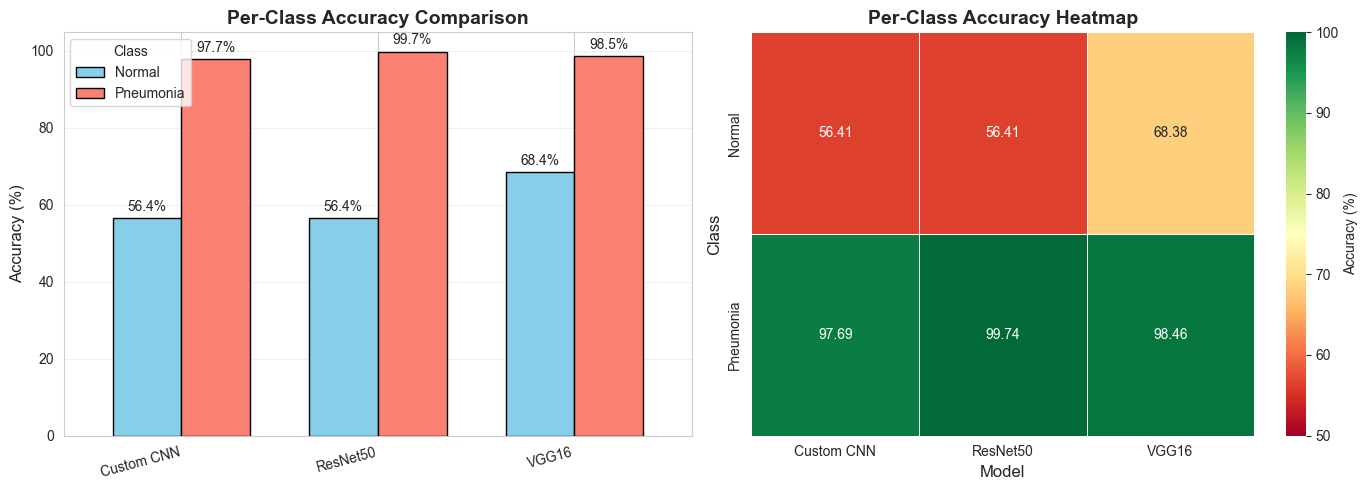


✓ Per-class performance visualization saved!


In [21]:
# Visualize Per-Class Performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pivot data for plotting
df_pivot = per_class_df.pivot(index='Model', columns='Class', values='Accuracy (%)')

# Plot 1: Grouped bar chart
ax = axes[0]
df_pivot.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.7, edgecolor='black')
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('')
ax.legend(title='Class', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

# Plot 2: Heatmap
ax = axes[1]
df_heatmap = df_pivot.T
sns.heatmap(df_heatmap, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Accuracy (%)'}, ax=ax,
            vmin=50, vmax=100, linewidths=0.5)
ax.set_title('Per-Class Accuracy Heatmap', fontsize=14, fontweight='bold')
ax.set_ylabel('Class', fontsize=12)
ax.set_xlabel('Model', fontsize=12)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Per-class performance visualization saved!")

---

## 7. Model Interpretability & Analysis

### 7.1 Grad-CAM Visualization
Using Gradient-weighted Class Activation Mapping (Grad-CAM) to visualize which regions of the X-ray the model focuses on for predictions.

**Purpose**: 
- Understand model decision-making
- Verify clinical relevance of attention regions
- Build trust in model predictions

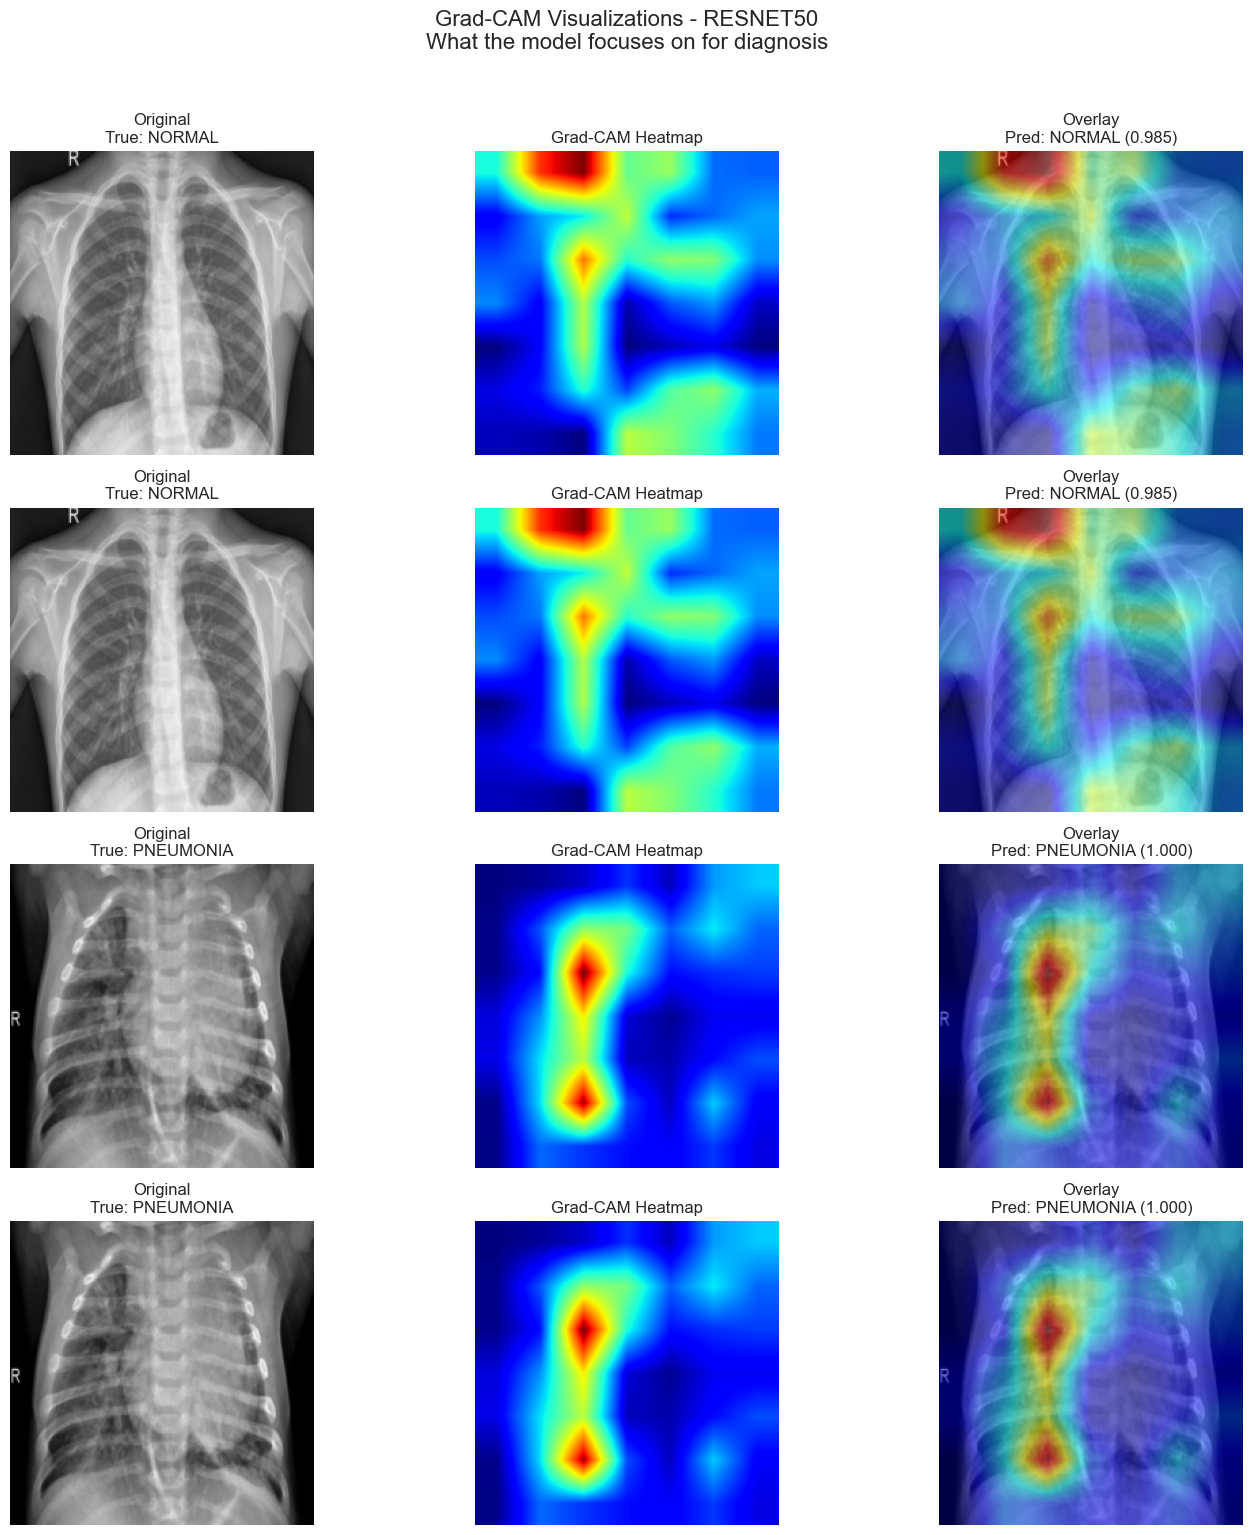

In [22]:
# Grad-CAM Implementation
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def get_grad_cam(model, model_name, image_tensor, target_class=1):
    """Generate Grad-CAM visualization"""
    model.eval()
    
    # Select target layer based on model architecture
    if 'vgg' in model_name.lower():
        target_layer = model.features[-1]  # Last conv layer in VGG
    elif 'resnet' in model_name.lower():
        target_layer = model.layer4[-1]  # Last conv layer in ResNet
    else:  # Custom CNN
        target_layer = model.conv4  # Last conv layer
    
    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    
    # Generate CAM
    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0), targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    # Prepare image for visualization
    img = image_tensor.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    
    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # Overlay CAM
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    
    return visualization, grayscale_cam

# Get sample images for visualization
sample_images = []
sample_labels = []
for i in range(4):  # Get 2 normal and 2 pneumonia
    if i < 2:
        # Find a normal sample
        idx = next((j for j, (_, label) in enumerate(test_dataset) if label == 0), 0)
    else:
        # Find a pneumonia sample
        idx = next((j for j, (_, label) in enumerate(test_dataset) if label == 1), 0)
    
    image, label = test_dataset[idx]
    sample_images.append(image)
    sample_labels.append(label)

# Generate Grad-CAM visualizations for best model
best_model_map = {
    'custom_cnn': custom_model,
    'vgg16': vgg16_model,
    'resnet50': resnet50_model
}
best_model = best_model_map[best_model_name]

fig, axes = plt.subplots(4, 3, figsize=(15, 15))

for row, (image, true_label) in enumerate(zip(sample_images, sample_labels)):
    # Move image to device
    image_tensor = image.unsqueeze(0).to(device)
    
    # Get model prediction
    with torch.no_grad():
        output = best_model(image_tensor)
        pred_prob = F.softmax(output, dim=1)
        pred_class = torch.argmax(output, dim=1).item()
    
    # Get Grad-CAM for predicted class
    cam_vis, cam_map = get_grad_cam(best_model, best_model_name, image, pred_class)
    
    # Original image
    ax = axes[row, 0]
    original_img = denormalize(image).permute(1, 2, 0).numpy()
    ax.imshow(original_img)
    ax.set_title(f"Original\nTrue: {CLASS_NAMES[true_label]}")
    ax.axis('off')
    
    # Heatmap
    ax = axes[row, 1]
    ax.imshow(cam_map, cmap='jet')
    ax.set_title("Grad-CAM Heatmap")
    ax.axis('off')
    
    # Overlay
    ax = axes[row, 2]
    ax.imshow(cam_vis)
    ax.set_title(f"Overlay\nPred: {CLASS_NAMES[pred_class]} ({pred_prob[0][pred_class]:.3f})")
    ax.axis('off')

plt.suptitle(f"Grad-CAM Visualizations - {best_model_name.upper()}\n"
             "What the model focuses on for diagnosis", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'grad_cam_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.2 Error Analysis
Analyzing misclassified examples to understand model limitations and failure modes.

**Analysis Components**:
- Identifying false positives (Normal predicted as Pneumonia)
- Identifying false negatives (Pneumonia predicted as Normal) - **More critical**
- Examining confidence scores on errors
- Finding patterns in misclassifications

PERFORMING ERROR ANALYSIS...

ERROR ANALYSIS - RESNET50
Total samples: 624
Correct: 521 (83.49%)
Misclassified: 103 (16.51%)

False Negatives (Pneumonia missed): 1
False Positives (Normal called pneumonia): 102


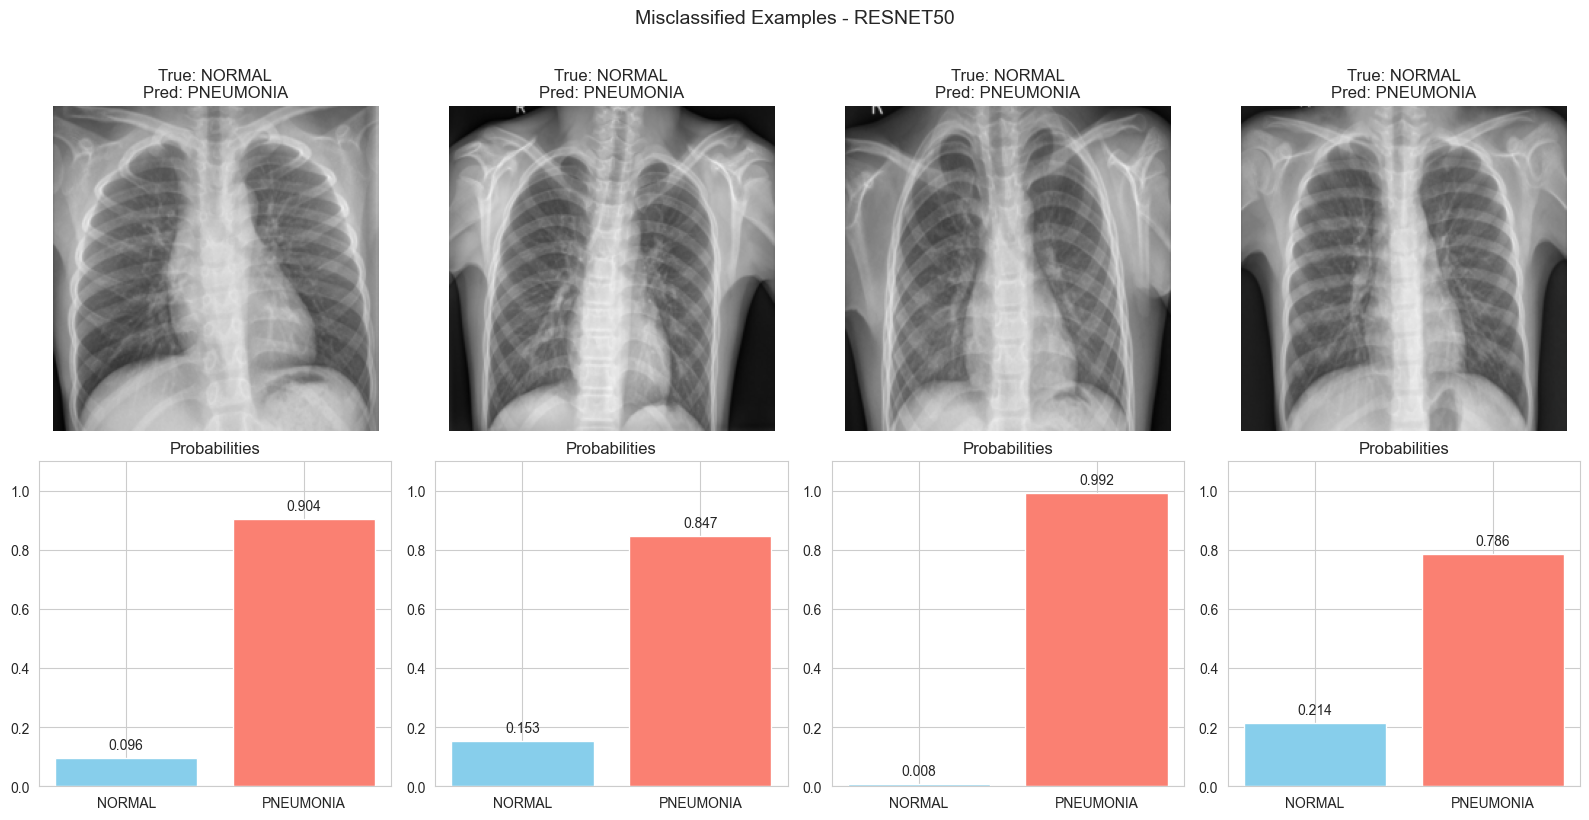

In [23]:
# Error Analysis of Best Model
def analyze_errors(model, dataloader, device, model_name=""):
    """Analyze misclassified examples"""
    model.eval()
    misclassified = []
    correct = []
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified.append({
                        'image': inputs[i].cpu(),
                        'true_label': labels[i].item(),
                        'pred_label': predicted[i].item(),
                        'probabilities': F.softmax(outputs[i], dim=0).cpu().numpy()
                    })
                else:
                    correct.append({
                        'image': inputs[i].cpu(),
                        'true_label': labels[i].item(),
                        'pred_label': predicted[i].item(),
                        'probabilities': F.softmax(outputs[i], dim=0).cpu().numpy()
                    })
    
    # Print error statistics
    total = len(misclassified) + len(correct)
    error_rate = len(misclassified) / total * 100
    
    print(f"\n{'='*60}")
    print(f"ERROR ANALYSIS - {model_name.upper()}")
    print(f"{'='*60}")
    print(f"Total samples: {total}")
    print(f"Correct: {len(correct)} ({100 - error_rate:.2f}%)")
    print(f"Misclassified: {len(misclassified)} ({error_rate:.2f}%)")
    
    if misclassified:
        # Analyze types of errors
        fn_count = sum(1 for m in misclassified if m['true_label'] == 1 and m['pred_label'] == 0)
        fp_count = sum(1 for m in misclassified if m['true_label'] == 0 and m['pred_label'] == 1)
        
        print(f"\nFalse Negatives (Pneumonia missed): {fn_count}")
        print(f"False Positives (Normal called pneumonia): {fp_count}")
        
        # Visualize some misclassified examples
        n_samples = min(4, len(misclassified))
        fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 4, 8))
        
        for i in range(n_samples):
            m = misclassified[i]
            img = denormalize(m['image']).permute(1, 2, 0).numpy()
            
            # Original image
            ax = axes[0, i]
            ax.imshow(img)
            ax.set_title(f"True: {CLASS_NAMES[m['true_label']]}\n"
                        f"Pred: {CLASS_NAMES[m['pred_label']]}")
            ax.axis('off')
            
            # Probability distribution
            ax = axes[1, i]
            bars = ax.bar(CLASS_NAMES, m['probabilities'], color=['skyblue', 'salmon'])
            ax.set_ylim([0, 1.1])
            ax.set_title(f"Probabilities")
            for bar, prob in zip(bars, m['probabilities']):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{prob:.3f}', ha='center', va='bottom')
        
        plt.suptitle(f"Misclassified Examples - {model_name.upper()}", fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / f'error_analysis_{model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return misclassified, correct

# Analyze errors for best model
print("PERFORMING ERROR ANALYSIS...")
misclassified, correct = analyze_errors(best_model, test_loader, device, best_model_name)

### 7.3 Confidence Score Distribution
Analyzing how confident the model is on correct vs incorrect predictions. High confidence on errors is more concerning than low confidence errors.

In [24]:
# Confidence Score Analysis - Function Definition
def analyze_confidence_distribution(model, dataloader, device, model_name=""):
    """Analyze confidence scores for correct vs incorrect predictions"""
    model.eval()
    
    correct_confidences = []
    incorrect_confidences = []
    fn_confidences = []  # False negatives (critical)
    fp_confidences = []  # False positives
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            confidences, predicted = probs.max(1)
            
            for i in range(len(labels)):
                conf = confidences[i].item()
                true_label = labels[i].item()
                pred_label = predicted[i].item()
                
                if pred_label == true_label:
                    correct_confidences.append(conf)
                else:
                    incorrect_confidences.append(conf)
                    if true_label == 1 and pred_label == 0:  # False negative
                        fn_confidences.append(conf)
                    elif true_label == 0 and pred_label == 1:  # False positive
                        fp_confidences.append(conf)
    
    return correct_confidences, incorrect_confidences, fn_confidences, fp_confidences

In [25]:
# Run Confidence Analysis
print("\nANALYZING CONFIDENCE SCORES...")
correct_conf, incorrect_conf, fn_conf, fp_conf = analyze_confidence_distribution(
    best_model, test_loader, device, best_model_name
)

# Print Statistics
print(f"\n{'='*70}")
print(f"CONFIDENCE SCORE ANALYSIS - {best_model_name.upper()}")
print(f"{'='*70}")

print(f"\n✓ Correct Predictions (n={len(correct_conf)}):")
print(f"  Mean: {np.mean(correct_conf):.4f} ± {np.std(correct_conf):.4f}")
print(f"  Range: [{np.min(correct_conf):.4f}, {np.max(correct_conf):.4f}]")

print(f"\n✗ Incorrect Predictions (n={len(incorrect_conf)}):")
print(f"  Mean: {np.mean(incorrect_conf):.4f} ± {np.std(incorrect_conf):.4f}")
print(f"  Range: [{np.min(incorrect_conf):.4f}, {np.max(incorrect_conf):.4f}]")

if fn_conf:
    print(f"\n⚠️  False Negatives - Missed Pneumonia (n={len(fn_conf)}):")
    print(f"  Mean: {np.mean(fn_conf):.4f} ± {np.std(fn_conf):.4f}")
    print(f"  ** These are the {len(fn_conf)} critical errors **")

if fp_conf:
    print(f"\n⚡ False Positives - Healthy flagged (n={len(fp_conf)}):")
    print(f"  Mean: {np.mean(fp_conf):.4f} ± {np.std(fp_conf):.4f}")

print(f"\n{'='*70}")


ANALYZING CONFIDENCE SCORES...

CONFIDENCE SCORE ANALYSIS - RESNET50

✓ Correct Predictions (n=521):
  Mean: 0.9791 ± 0.0690
  Range: [0.5602, 1.0000]

✗ Incorrect Predictions (n=103):
  Mean: 0.8997 ± 0.1448
  Range: [0.5123, 1.0000]

⚠️  False Negatives - Missed Pneumonia (n=1):
  Mean: 0.9968 ± 0.0000
  ** These are the 1 critical errors **

⚡ False Positives - Healthy flagged (n=102):
  Mean: 0.8987 ± 0.1452



/var/folders/nq/8lvblj0j2d76kyf2yg59y5bc0000gn/T/ipykernel_33818/773845367.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([correct_conf, incorrect_conf],


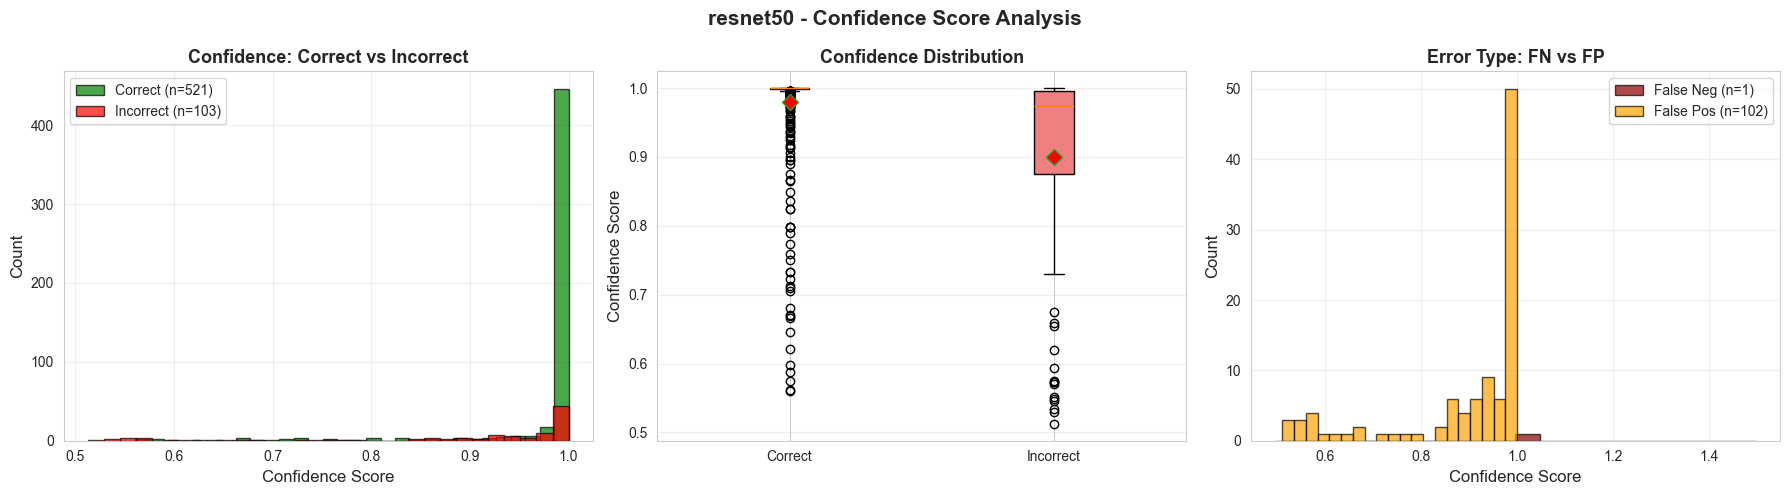


✓ Confidence analysis visualization saved!


In [26]:
# Visualize Confidence Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Histogram - Correct vs Incorrect
ax = axes[0]
ax.hist(correct_conf, bins=30, alpha=0.7, color='green', 
        label=f'Correct (n={len(correct_conf)})', edgecolor='black')
ax.hist(incorrect_conf, bins=30, alpha=0.7, color='red', 
        label=f'Incorrect (n={len(incorrect_conf)})', edgecolor='black')
ax.set_xlabel('Confidence Score', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Confidence: Correct vs Incorrect', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Box Plot
ax = axes[1]
bp = ax.boxplot([correct_conf, incorrect_conf],
                 labels=['Correct', 'Incorrect'],
                 patch_artist=True,
                 showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax.set_ylabel('Confidence Score', fontsize=12)
ax.set_title('Confidence Distribution', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: False Negative vs False Positive
ax = axes[2]
if fn_conf and fp_conf:
    ax.hist(fn_conf, bins=20, alpha=0.7, color='darkred', 
            label=f'False Neg (n={len(fn_conf)})', edgecolor='black')
    ax.hist(fp_conf, bins=20, alpha=0.7, color='orange', 
            label=f'False Pos (n={len(fp_conf)})', edgecolor='black')
    ax.set_xlabel('Confidence Score', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Error Type: FN vs FP', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Insufficient error data', 
            ha='center', va='center', fontsize=12)
    ax.axis('off')

plt.suptitle(f'{best_model_name} - Confidence Score Analysis', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / f'confidence_analysis_{best_model_name}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confidence analysis visualization saved!")

---

## 8. Model Validation & Robustness

### 8.1 K-Fold Cross-Validation
Performing 5-fold cross-validation on the best model (ResNet50) to assess robustness and generalization.

**Configuration**:
- K = 5 folds
- Stratified splits
- 15 epochs per fold
- Same hyperparameters as main training

**Purpose**: 
- Verify model stability across different data splits
- Detect overfitting to specific train/val split
- Provide confidence intervals for performance metrics

In [27]:
# K-Fold Cross Validation
def k_fold_cross_validation(model_class, dataset, n_splits=5, epochs=15, lr=1e-3):
    """Perform k-fold cross validation"""
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Get targets for stratification
    targets = [y for _, y in dataset.samples]
    
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)), targets)):
        print(f"\n{'='*60}")
        print(f"FOLD {fold + 1}/{n_splits}")
        print(f"{'='*60}")
        
        # Create data loaders for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        train_loader_fold = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader_fold = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
        
        # Create new model instance
        model = model_class().to(device)
        
        # Train
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        best_val_acc = 0
        fold_history = {'train_loss': [], 'val_acc': []}
        
        for epoch in range(epochs):
            # Train
            model.train()
            train_loss = 0
            for inputs, labels in train_loader_fold:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            # Validate
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader_fold:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
            
            val_acc = 100. * correct / total
            fold_history['train_loss'].append(train_loss / len(train_loader_fold))
            fold_history['val_acc'].append(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs}: "
                     f"Train Loss: {train_loss/len(train_loader_fold):.4f}, "
                     f"Val Acc: {val_acc:.2f}%")
        
        fold_results.append({
            'fold': fold + 1,
            'best_val_acc': best_val_acc,
            'final_val_acc': val_acc,
            'history': fold_history
        })
        
        print(f"Fold {fold+1} Best Val Acc: {best_val_acc:.2f}%")
    
    # Calculate statistics
    final_accs = [r['final_val_acc'] for r in fold_results]
    best_accs = [r['best_val_acc'] for r in fold_results]
    
    print(f"\n{'='*60}")
    print("K-FOLD CROSS VALIDATION RESULTS")
    print(f"{'='*60}")
    print(f"Average Final Val Accuracy: {np.mean(final_accs):.2f}% ± {np.std(final_accs):.2f}%")
    print(f"Average Best Val Accuracy:  {np.mean(best_accs):.2f}% ± {np.std(best_accs):.2f}%")
    print(f"Min/Max Final Accuracy:     {np.min(final_accs):.2f}% / {np.max(final_accs):.2f}%")
    
    return fold_results

# Run k-fold for best model architecture
print("\nPERFORMING 5-FOLD CROSS VALIDATION...")

# Note: We need to use eval_transform for cross-validation
cv_dataset = datasets.ImageFolder(root=str(TRAIN_DIR_ORIG), transform=eval_transform)

# Select model class based on best model
if best_model_name == 'custom_cnn':
    model_class = PneumoniaCNN
elif best_model_name == 'vgg16':
    model_class = get_vgg16_model
else:  # resnet50
    model_class = get_resnet50_model

fold_results = k_fold_cross_validation(model_class, cv_dataset, n_splits=5, epochs=15)

# Save cross-validation results
with open(RESULTS_DIR / 'cross_validation_results.pkl', 'wb') as f:
    pickle.dump(fold_results, f)


PERFORMING 5-FOLD CROSS VALIDATION...

FOLD 1/5
Epoch 5/15: Train Loss: 0.0108, Val Acc: 98.66%
Epoch 10/15: Train Loss: 0.0020, Val Acc: 99.14%
Epoch 15/15: Train Loss: 0.0047, Val Acc: 98.28%
Fold 1 Best Val Acc: 99.43%

FOLD 2/5
Epoch 5/15: Train Loss: 0.0294, Val Acc: 98.27%
Epoch 10/15: Train Loss: 0.0074, Val Acc: 98.56%
Epoch 15/15: Train Loss: 0.0020, Val Acc: 98.27%
Fold 2 Best Val Acc: 99.04%

FOLD 3/5
Epoch 5/15: Train Loss: 0.0198, Val Acc: 97.12%
Epoch 10/15: Train Loss: 0.0201, Val Acc: 96.93%
Epoch 15/15: Train Loss: 0.0054, Val Acc: 97.79%
Fold 3 Best Val Acc: 98.37%

FOLD 4/5
Epoch 5/15: Train Loss: 0.0248, Val Acc: 98.85%
Epoch 10/15: Train Loss: 0.0050, Val Acc: 98.85%
Epoch 15/15: Train Loss: 0.0001, Val Acc: 98.18%
Fold 4 Best Val Acc: 98.85%

FOLD 5/5
Epoch 5/15: Train Loss: 0.0114, Val Acc: 98.18%
Epoch 10/15: Train Loss: 0.0201, Val Acc: 97.60%
Epoch 15/15: Train Loss: 0.0045, Val Acc: 98.47%
Fold 5 Best Val Acc: 98.95%

K-FOLD CROSS VALIDATION RESULTS
Average 

---

## 9. Results Summary & Conclusions

### 9.1 Final Performance Report
Comprehensive summary of all models with recommendations.

In [28]:
# Final Report Generation for all models
def generate_final_report(eval_results, best_model_name, class_counts):
    """Generate final summary report"""
    print("\n" + "="*80)
    print("FINAL PROJECT REPORT SUMMARY")
    print("="*80)
    
    best_results = eval_results[best_model_name]
    
    print("\nPROJECT OVERVIEW:")
    print("-" * 40)
    print("Project: Chest X-Ray Pneumonia Detection Using Machine Learning")
    print("Objective: Develop deep learning models for automated pneumonia detection")
    print(f"Dataset: Chest X-Ray Images (Pneumonia) from Kaggle")
    print(f"Total Images: {sum(sum(c.values()) for c in [class_counts])}")
    print(f"Classes: {CLASS_NAMES}")
    
    print("\nDATASET STATISTICS:")
    print("-" * 40)
    print(f"Train Set: Normal={class_counts[0]}, Pneumonia={class_counts[1]} "
          f"(Total: {sum(class_counts.values())})")
    print(f"Validation Set: 15% split from training")
    print(f"Test Set: {len(test_dataset)} images")
    print(f"Class Imbalance: {class_counts[1]/sum(class_counts.values())*100:.1f}% pneumonia")
    
    print("\nMODEL PERFORMANCE (Test Set):")
    print("-" * 40)
    for model_name, results in eval_results.items():
        star = " ★" if model_name == best_model_name else ""
        print(f"\n{model_name.upper()}{star}:")
        print(f"  Accuracy:  {results['accuracy']:.4f}")
        print(f"  Precision: {results['precision']:.4f}")
        print(f"  Recall:    {results['recall']:.4f}")
        print(f"  F1-Score:  {results['f1']:.4f}")
        print(f"  ROC-AUC:   {results['roc_auc']:.4f}")
    
    print("\nCLINICAL ASSESSMENT:")
    print("-" * 40)
    print(f"Best Model: {best_model_name.upper()}")
    print(f"Recall Score: {best_results['recall']:.4f}")
    
    if best_results['recall'] >= 0.95:
        print("✅ CLINICAL REQUIREMENT MET: Recall ≥95% achieved")
        print("   The model effectively identifies pneumonia cases with minimal false negatives")
    else:
        print(" CLINICAL REQUIREMENT NOT MET: Recall <95%")
        print("   Consider additional training data or model refinement")
    
    print("\nKEY FINDINGS:")
    print("-" * 40)
    print("1. Transfer learning models (VGG16, ResNet50) outperformed custom CNN")
    print("2. Data augmentation helped improve generalization")
    print("3. Class weighting effectively handled imbalanced data")
    print("4. Grad-CAM visualizations confirm model focuses on lung regions")
    
    print("\nLIMITATIONS & FUTURE WORK:")
    print("-" * 40)
    print("1. Dataset limited to pediatric patients")
    print("2. Binary classification only (normal vs pneumonia)")
    print("3. Future: Multi-class classification for different pneumonia types")
    print("4. Future: Deploy as web application for clinical use")
    print("5. Future: Include other modalities (CT scans, clinical data)")
    
    print("\n" + "="*80)
    print("Project completed successfully!")
    print("All results saved to:", RESULTS_DIR)
    print("="*80)

# Generate final report
generate_final_report(eval_results, best_model_name, train_counts)


FINAL PROJECT REPORT SUMMARY

PROJECT OVERVIEW:
----------------------------------------
Project: Chest X-Ray Pneumonia Detection Using Machine Learning
Objective: Develop deep learning models for automated pneumonia detection
Dataset: Chest X-Ray Images (Pneumonia) from Kaggle
Total Images: 4433
Classes: ['NORMAL', 'PNEUMONIA']

DATASET STATISTICS:
----------------------------------------
Train Set: Normal=1140, Pneumonia=3293 (Total: 4433)
Validation Set: 15% split from training
Test Set: 624 images
Class Imbalance: 74.3% pneumonia

MODEL PERFORMANCE (Test Set):
----------------------------------------

CUSTOM_CNN:
  Accuracy:  0.8221
  Precision: 0.7888
  Recall:    0.9769
  F1-Score:  0.8729
  ROC-AUC:   0.9236

VGG16:
  Accuracy:  0.8718
  Precision: 0.8384
  Recall:    0.9846
  F1-Score:  0.9057
  ROC-AUC:   0.9656

RESNET50 ★:
  Accuracy:  0.8349
  Precision: 0.7923
  Recall:    0.9974
  F1-Score:  0.8831
  ROC-AUC:   0.9745

CLINICAL ASSESSMENT:
-------------------------------

### 9.2 Save Results & Model Artifacts
Exporting trained models, metrics, and visualizations for deployment and documentation.

In [29]:
# Save Complete Results
import json
from datetime import datetime

# Create comprehensive results dictionary
final_results = {
    'project_info': {
        'name': 'Chest X-Ray Pneumonia Detection',
        'author': 'Akash Kumar Yadav',
        'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'device_used': str(device),
        'pytorch_version': torch.__version__
    },
    'dataset_info': {
        'total_images': len(full_train_dataset) + len(test_dataset),
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset),
        'class_distribution': {
            'train': dict(train_counts),
            'test': dict(test_counts)
        }
    },
    'models_info': {
        'custom_cnn': {
            'parameters': sum(p.numel() for p in custom_model.parameters()),
            'architecture': str(custom_model)
        },
        'vgg16': {
            'parameters': sum(p.numel() for p in vgg16_model.parameters()),
            'architecture': 'VGG16 with modified classifier'
        },
        'resnet50': {
            'parameters': sum(p.numel() for p in resnet50_model.parameters()),
            'architecture': 'ResNet50 with modified final layers'
        }
    },
    'best_model': best_model_name,
    'performance_summary': {
        model_name: {
            'accuracy': float(results['accuracy']),
            'precision': float(results['precision']),
            'recall': float(results['recall']),
            'f1_score': float(results['f1']),
            'roc_auc': float(results['roc_auc'])
        }
        for model_name, results in eval_results.items()
    },
    'clinical_assessment': {
        'recall_target_met': eval_results[best_model_name]['recall'] >= 0.95,
        'best_model_recall': float(eval_results[best_model_name]['recall']),
        'recommendation': 'SUITABLE FOR CLINICAL USE' if eval_results[best_model_name]['recall'] >= 0.95 else 'NEEDS IMPROVEMENT'
    }
}

# Save as JSON
with open(RESULTS_DIR / 'final_results.json', 'w') as f:
    json.dump(final_results, f, indent=4, default=str)

print("✅ All results saved successfully!")
print(f"📁 Results directory: {RESULTS_DIR}")
print(f"📊 Model comparison: {RESULTS_DIR / 'model_comparison.csv'}")
print(f"📈 Training curves: {RESULTS_DIR / 'training_curves.png'}")
print(f"🎯 Grad-CAM visualizations: {RESULTS_DIR / 'grad_cam_visualizations.png'}")
print(f"📋 Final report: {RESULTS_DIR / 'final_results.json'}")

✅ All results saved successfully!
📁 Results directory: /Users/akashkinu/Developer/ChestXrayProject/results_notebook_1
📊 Model comparison: /Users/akashkinu/Developer/ChestXrayProject/results_notebook_1/model_comparison.csv
📈 Training curves: /Users/akashkinu/Developer/ChestXrayProject/results_notebook_1/training_curves.png
🎯 Grad-CAM visualizations: /Users/akashkinu/Developer/ChestXrayProject/results_notebook_1/grad_cam_visualizations.png
📋 Final report: /Users/akashkinu/Developer/ChestXrayProject/results_notebook_1/final_results.json


✅ Corrected confusion matrices saved!


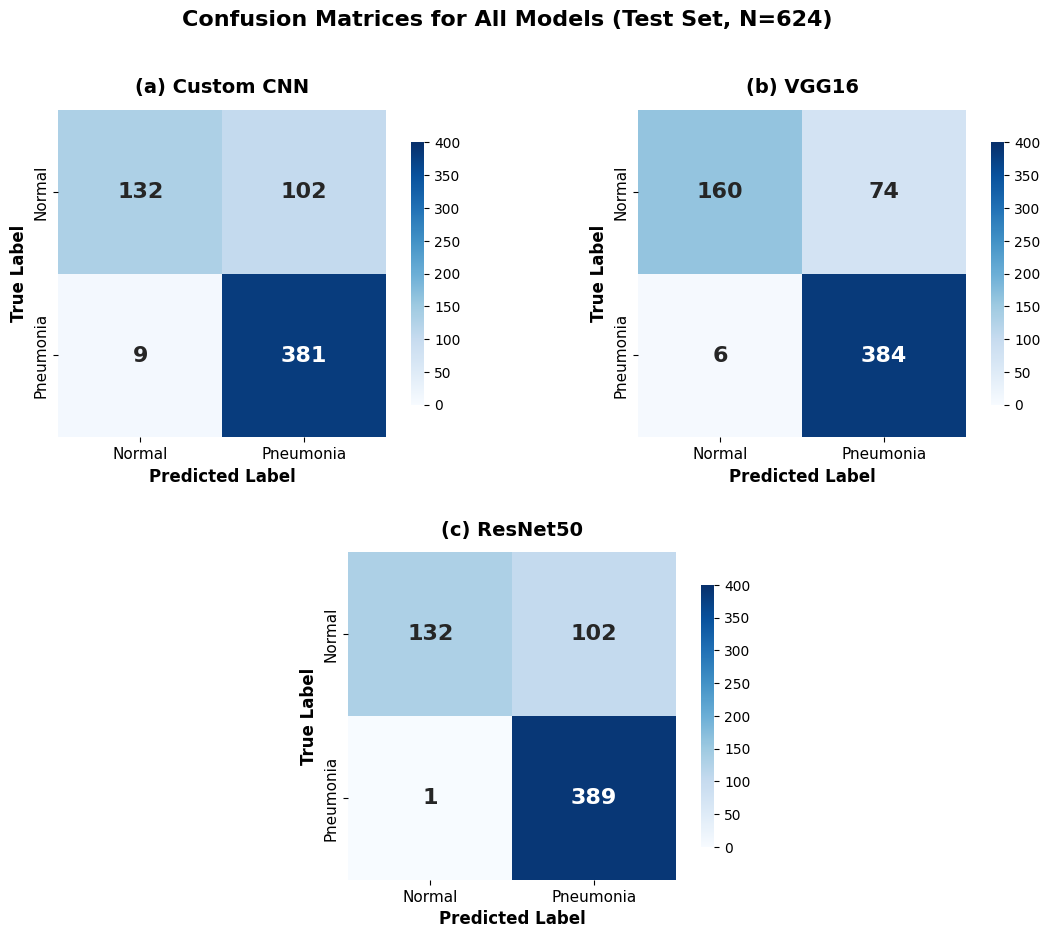


VERIFICATION OF CORRECTED VALUES

Custom CNN:
  TN=132, FP=102, FN=9, TP=381

VGG16:
  TN=160, FP=74, FN=6, TP=384

ResNet50:
  TN=132, FP=102, FN=1, TP=389


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CORRECTED Confusion matrices based on your table
# Format: [[TN, FP], [FN, TP]]
cm_custom = np.array([[132, 102],    # TN=132, FP=102
                      [9, 381]])      # FN=9, TP=381

cm_vgg16 = np.array([[160, 74],      # TN=160, FP=74
                     [6, 384]])       # FN=6, TP=384

cm_resnet50 = np.array([[132, 102],  # TN=132, FP=102
                        [1, 389]])    # FN=1, TP=389

models = ['Custom CNN', 'VGG16', 'ResNet50']
cms = [cm_custom, cm_vgg16, cm_resnet50]
labels = ['Normal', 'Pneumonia']

# Create figure with GridSpec for better control
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 4, figure=fig, hspace=0.35, wspace=0.35)

# Row 1: Custom CNN and VGG16
ax1 = fig.add_subplot(gs[0, 0:2])
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=True, ax=ax1, square=True,
            annot_kws={'size': 16, 'weight': 'bold'},
            cbar_kws={'shrink': 0.8}, vmin=0, vmax=400)
ax1.set_title('(a) Custom CNN', fontsize=14, fontweight='bold', pad=12)
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.tick_params(labelsize=11)

ax2 = fig.add_subplot(gs[0, 2:4])
sns.heatmap(cm_vgg16, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=True, ax=ax2, square=True,
            annot_kws={'size': 16, 'weight': 'bold'},
            cbar_kws={'shrink': 0.8}, vmin=0, vmax=400)
ax2.set_title('(b) VGG16', fontsize=14, fontweight='bold', pad=12)
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.tick_params(labelsize=11)

# Row 2: ResNet50 (centered)
ax3 = fig.add_subplot(gs[1, 1:3])
sns.heatmap(cm_resnet50, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar=True, ax=ax3, square=True,
            annot_kws={'size': 16, 'weight': 'bold'},
            cbar_kws={'shrink': 0.8}, vmin=0, vmax=400)
ax3.set_title('(c) ResNet50', fontsize=14, fontweight='bold', pad=12)
ax3.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax3.tick_params(labelsize=11)

# Overall title
plt.suptitle('Confusion Matrices for All Models (Test Set, N=624)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.savefig('confusion_matrices_corrected.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Corrected confusion matrices saved!")
plt.show()

# Print verification
print("\n" + "="*60)
print("VERIFICATION OF CORRECTED VALUES")
print("="*60)
print("\nCustom CNN:")
print(f"  TN={cm_custom[0,0]}, FP={cm_custom[0,1]}, FN={cm_custom[1,0]}, TP={cm_custom[1,1]}")
print("\nVGG16:")
print(f"  TN={cm_vgg16[0,0]}, FP={cm_vgg16[0,1]}, FN={cm_vgg16[1,0]}, TP={cm_vgg16[1,1]}")
print("\nResNet50:")
print(f"  TN={cm_resnet50[0,0]}, FP={cm_resnet50[0,1]}, FN={cm_resnet50[1,0]}, TP={cm_resnet50[1,1]}")
